In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from IPython.display import Image # to display images

print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 2.9.0+cu126 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=12755239-1633-0549-f74f-b4e4e09e4362, pci_bus_id=0, pci_device_id=4, pci_domain_id=0, L2_cache_size=4MB)


In [ ]:
N_CLASSES       = 1
EPOCHS          = 80
LEARNING_RATE   = 0.002
START_FRAME     = 16
DROP_RATE       = 0.2 #0.3
RUN_NAME        = 'worm'

DATA_PATH       = '/content/drive/MyDrive/worm_size'
IMAGE_PATH      = DATA_PATH +'/org'
MASK_PATH       = DATA_PATH+'/mask'
#TEST_IMAGE_PATH = 'test/images/'
#TEST_MASK_PATH  = 'test/masks/'
IMAGE_TYPE      = '.png'
MASK_TYPE       = '.png'
LOG_PATH        = '/content/drive/MyDrive/worm_size/log'
SAVE_PATH       = '/content/drive/MyDrive/worm_size/save/'

REAL_HEIGHT     = 512
REAL_WIDTH      = 521
IMG_HEIGHT      = 521 #720
IMG_WIDTH       = 521 #1280
RANDOM_SEED     = 26
VALID_RATIO     = 0.2
BATCH_SIZE      = 10 #16
NUM_WORKERS     = 0
CLASSES         = {1:'worm'}

In [ ]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, dataloader, random_split

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
import pandas as pd

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(LOG_PATH)

In [ ]:
epochs=[]

tra_loss=[]
tra_iou=[]
val_loss=[]
val_iou=[]

In [ ]:
class MY_Dataset(Dataset):
    """Pothole Identification dataset."""

    def __init__(self, root_dir=DATA_PATH, transform=None):
        """
        Args:
            root_path (string): Directory with all the images.
            transformer (function): whether to apply the data augmentation scheme
                mentioned in the paper. Only applied on the train split.
        """

        # load dataset from root dir
        self.root_dir   = root_dir
        listname =[]
        for imgfile in os.listdir(DATA_PATH+'/org/'):
            if os.path.splitext(imgfile)[1] == IMAGE_TYPE:
                filename = os.path.splitext(imgfile)[0]
                listname.append(filename)
        self.ids        = listname #train_df.index

        if transform is None:
            self.transfrom = transforms.Compose([#transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
                                                 transforms.Grayscale(),
                                                 transforms.ToTensor(),])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id    = self.ids[index]

        # file should be unzipped
        image = Image.open(self.root_dir+'/org/'+id + IMAGE_TYPE)
        mask  = Image.open(self.root_dir+'/mask/'+id + MASK_TYPE)

        image = self.transfrom(image)
        mask  = self.transfrom(mask)

        return image, mask

In [ ]:
def get_dataloader (dataset , batch_size = BATCH_SIZE , random_seed= RANDOM_SEED,
                    valid_ratio= VALID_RATIO, shuffle=True, num_workers=NUM_WORKERS):

  #split dataset
  n=len(dataset)
  n_valid = int(valid_ratio*n)
  n_train = n - n_valid

  #init random seed
  torch.manual_seed(random_seed)

  train_dataset, valid_dataset = random_split(dataset, (n_train, n_valid))

  train_loader = DataLoader(train_dataset, batch_size, shuffle=shuffle, num_workers=num_workers)
  valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=num_workers)

  return train_loader, valid_loader

In [ ]:
dataset=MY_Dataset(DATA_PATH )

trainloader, validloader = get_dataloader(dataset=dataset)

In [ ]:
def show_dataset(dataset, n_sample=4):
    """Visualize dataset with n_sample"""
    plt.figure(figsize=(30, 15))

    # show image
    for i in range(n_sample):
        image, mask = dataset[i]
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        print(i, image.size, mask.size)


        plt.tight_layout()
        ax = plt.subplot(n_sample, 1, i + 1)
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        plt.imshow(image, cmap="Greys")
        plt.imshow(mask, alpha=0.3, cmap="OrRd")

        if i == n_sample-1:
            plt.show()
            break

0 (512, 512) (512, 512)
1 (512, 512) (512, 512)
2 (512, 512) (512, 512)
3 (512, 512) (512, 512)


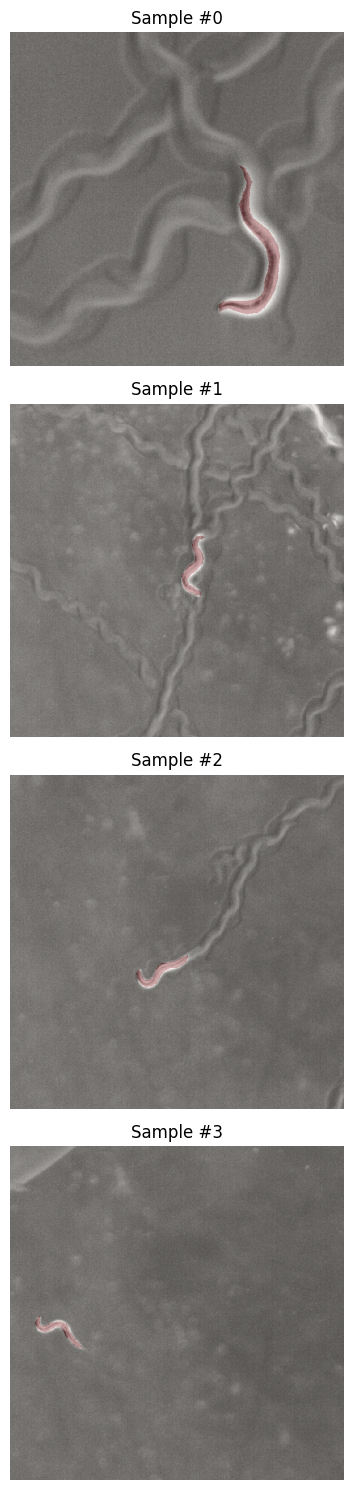

In [ ]:
show_dataset(dataset)

In [ ]:
class BatchActivate(nn.Module):
    def __init__(self, num_features):
        super(BatchActivate, self).__init__()
        self.norm = nn.BatchNorm2d(num_features)

    def forward(self, x):
        return F.relu(self.norm(x))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3, padding=1, stride=1, activation=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                            kernel_size=kernel, stride=stride, padding=padding)
        self.batchnorm  = BatchActivate(out_channels)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        if self.activation:
            x = self.batchnorm(x)
        return x

class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3, padding=1, stride=1):
        super(DoubleConvBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel, padding, stride)
        self.conv2 = ConvBlock(out_channels, out_channels, kernel, padding, stride)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, batch_activation=False):
        super(ResidualBlock, self).__init__()
        self.batch_activation = batch_activation
        self.norm  = nn.BatchNorm2d(num_features=in_channels)
        self.conv1 = ConvBlock(in_channels, in_channels, kernel=3, stride=1, padding=1)
        self.conv2 = ConvBlock(in_channels, in_channels, kernel=3, stride=1, padding=1, activation=False)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.conv1(x)
        x = self.conv2(x)

        x += residual
        # x = x.view(x.size(0),-1)

        if self.batch_activation:
            x = self.norm(x)

        return x

In [ ]:
class UNet_ResNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=N_CLASSES, dropout=0.1, start_fm=START_FRAME):
        super(UNet_ResNet, self).__init__()
        #Dropout
        self.drop = dropout
        #Pooling
        self.pool = nn.MaxPool2d((2,2))

        # Encoder
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(in_channels, start_fm, 3, padding=(1,1)),
            ResidualBlock(start_fm),
            ResidualBlock(start_fm, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout//2),
        )

        self.encoder_2 = nn.Sequential(
            nn.Conv2d(start_fm, start_fm*2, 3, padding=(1,1)),
            ResidualBlock(start_fm*2),
            ResidualBlock(start_fm*2, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout),
        )

        self.encoder_3 = nn.Sequential(
            nn.Conv2d(start_fm*2, start_fm*4, 3, padding=(1,1)),
            ResidualBlock(start_fm*4),
            ResidualBlock(start_fm*4, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout),
        )

        self.encoder_4 = nn.Sequential(
            nn.Conv2d(start_fm*4, start_fm*8, 3, padding=(1,1)),
            ResidualBlock(start_fm*8),
            ResidualBlock(start_fm*8, batch_activation=True),
#             nn.MaxPool2d((2,2)),
#             nn.Dropout2d(dropout),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(start_fm*8, start_fm*16, 3, padding=3//2),
            ResidualBlock(start_fm*16),
            ResidualBlock(start_fm*16, batch_activation=True),
#             nn.MaxPool2d((2,2))
        )

        # Transpose conv
        self.deconv_4  = nn.ConvTranspose2d(start_fm*16, start_fm*8, 2, 2)
        self.deconv_3  = nn.ConvTranspose2d(start_fm*8, start_fm*4, 2, 2)
        self.deconv_2  = nn.ConvTranspose2d(start_fm*4, start_fm*2, 2, 2)
        self.deconv_1  = nn.ConvTranspose2d(start_fm*2, start_fm, 2, 2)

        # Decoder
        self.decoder_4 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*16, start_fm*8, 3, padding=(1,1)),
            ResidualBlock(start_fm*8),
            ResidualBlock(start_fm*8, batch_activation=True),
        )

        self.decoder_3 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*8, start_fm*4, 3, padding=(1,1)),
            ResidualBlock(start_fm*4),
            ResidualBlock(start_fm*4, batch_activation=True),
        )

        self.decoder_2 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*4, start_fm*2, 3, padding=(1,1)),
            ResidualBlock(start_fm*2),
            ResidualBlock(start_fm*2, batch_activation=True),
        )

        self.decoder_1 = nn.Sequential(
            nn.Dropout2d(dropout),
            nn.Conv2d(start_fm*2, start_fm, 3, padding=(1,1)),
            ResidualBlock(start_fm),
            ResidualBlock(start_fm, batch_activation=True),
        )

        self.conv_last = nn.Conv2d(start_fm, n_classes, 1)

    def forward(self, x):
        # Encoder

        conv1 = self.encoder_1(x) #128
        x = self.pool(conv1) # 64
        x = nn.Dropout2d(self.drop)(x)

        conv2 = self.encoder_2(x) #64
        x = self.pool(conv2) # 32
        x = nn.Dropout2d(self.drop)(x)

        conv3 = self.encoder_3(x) #32
        x = self.pool(conv3) #16
        x = nn.Dropout2d(self.drop)(x)

        conv4 = self.encoder_4(x) #16
        x = self.pool(conv4) # 8
        x = nn.Dropout2d(self.drop)(x)


        # Middle
        x     = self.middle(x) # 8

        # Decoder
        x     = self.deconv_4(x) #16
        x     = torch.cat([conv4, x], dim=1) #16
        x     = self.decoder_4(x)


        x     = self.deconv_3(x) #32
        x     = torch.cat([conv3, x], dim=1)
        x     = self.decoder_3(x)


        x     = self.deconv_2(x) #64
        x     = torch.cat([conv2, x], dim=1)
        x     = self.decoder_2(x)


        x     = self.deconv_1(x) # 128
        x     = torch.cat([conv1, x], dim=1)
        x     = self.decoder_1(x)

        out   = (self.conv_last(x)) # 128
        return out

In [ ]:
def labels():
  l = {}
  for i, label in enumerate(CLASSES):
    l[i] = label
  return l

def tensor2np(tensor):
    tensor = tensor.squeeze().cpu()
    return tensor.detach().numpy()

def normtensor(tensor):
    tensor = torch.where(tensor<0., torch.zeros(1).cuda(), torch.ones(1).cuda())
    return tensor

def count_params(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    return pytorch_total_params

In [ ]:
def get_iou_score(outputs, labels):
    A = labels.squeeze(1).bool()
    pred = torch.where(outputs<0., torch.zeros(1).cuda(), torch.ones(1).cuda())
    B = pred.squeeze(1).bool()
    intersection = (A & B).float().sum((1,2))
    union = (A| B).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou.cpu().detach().numpy()

In [ ]:
def train(model, device, trainloader, optimizer, loss_function, epoch):
    model.train()
    running_loss = 0
    mask_list, iou = [], []
    for i, (input, mask) in enumerate(trainloader):
        # load data into cuda
        input, mask = input.to(device), mask.to(device)

        # forward
        predict = model(input)
        loss = loss_function(predict, mask)

        # metric
        iou.append(get_iou_score(predict, mask).mean())
        running_loss += (loss.item())

        # zero the gradient + backprpagation + step
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # log the first image of the batch
        if ((i + 1) % 10) == 0:
            pred = normtensor(predict[0])
            img, pred, mak = tensor2np(input[0]), tensor2np(pred), tensor2np(mask[0])

    mean_iou = np.mean(iou)
    total_loss = running_loss/len(trainloader)
    #writer.add_scalar('training loss',
                        #total_loss,
                        #epoch)

    return total_loss, mean_iou

In [ ]:
def test(model, device, testloader, loss_function, best_iou, epoch):
    model.eval()
    running_loss = 0
    mask_list, iou  = [], []
    with torch.no_grad():
        for i, (input, mask) in enumerate(testloader):
            input, mask = input.to(device), mask.to(device)

            predict = model(input)
            loss = loss_function(predict, mask)

            running_loss += loss.item()
            iou.append(get_iou_score(predict, mask).mean())

            # log the first image of the batch
            if ((i + 1) % 1) == 0:
                pred = normtensor(predict[0])
                img, pred, mak = tensor2np(input[0]), tensor2np(pred), tensor2np(mask[0])

    test_loss = running_loss/len(testloader)
    mean_iou = np.mean(iou)

   # writer.add_scalar('val loss',
    #                 test_loss,
     #                epoch)

    if mean_iou>best_iou:


        save_name = f"{RUN_NAME}_epoch{epoch:03d}_iou{mean_iou:.4f}.pth"
        save_path = os.path.join(SAVE_PATH, save_name)
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved model: {save_name}")


    return test_loss, mean_iou

In [ ]:
def model_pipeline(prev_model = None):
    best_model = None


    # make the model, data, and optimization
    model, criterion, optimizer = make_model(prev_model)



    best_iou = -1

    for epoch in range(EPOCHS):

        t0 = time.time()
        train_loss, train_iou = train(model, device, trainloader, optimizer, criterion, epoch)
        t1 = time.time()

        print(f'Epoch: {epoch} | Train loss: {train_loss:.3f} | Train IoU: {train_iou:.3f} | Time: {(t1-t0):.1f}s')

        test_loss, test_iou = test(model, device, validloader, criterion, best_iou, epoch)
        print(f'Epoch: {epoch} | Valid loss: {test_loss:.3f} | Valid IoU: {test_iou:.3f} | Time: {(t1-t0):.1f}s')

        epochs.append(epoch)

        tra_loss.append(train_loss)
        tra_iou.append(train_iou)
        val_loss.append(test_loss)
        val_iou.append(test_iou)



        if test_iou > best_iou:

          best_iou = test_iou
          best_model = copy.deepcopy(model)
          print(f"🌟 New best IoU: {best_iou:.4f}")





    log_train = {}
    log_train['epoch'] = epochs
    log_train['tra_loss'] = tra_loss
    log_train['tra_iou'] = tra_iou
    df_train_log = pd.DataFrame(log_train)
    df_train_log.to_csv('/content/drive/MyDrive/worm_size/log_csv/unet_train_data.csv', index=False)

    log_valiation ={}
    log_valiation['epoch'] = epochs
    log_valiation['val_loss'] = val_loss
    log_valiation['val_iou'] = val_iou
    df_val_log = pd.DataFrame(log_valiation)
    df_val_log.to_csv('/content/drive/MyDrive/worm_size/log_csv/unet_val_data.csv', index=False)



    return best_model, tra_iou, tra_loss, val_loss, val_iou

In [ ]:
def make_model(prev_model = None):
    # Make the model
    if prev_model == None:
        model = UNet_ResNet().to(device)
    else:
        model = prev_model

    print('Number of parameter:', count_params(model))

    # Make the loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer   = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    return model, criterion, optimizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = model_pipeline(prev_model=None)
# tensorboard --logdir=runs

Number of parameter: 4896369
Epoch: 0 | Train loss: 0.714 | Train IoU: 0.143 | Time: 69.0s
✅ Saved model: worm_epoch000_iou0.0219.pth
Epoch: 0 | Valid loss: 1.544 | Valid IoU: 0.022 | Time: 69.0s
🌟 New best IoU: 0.0219
Epoch: 1 | Train loss: 0.658 | Train IoU: 0.265 | Time: 7.4s
✅ Saved model: worm_epoch001_iou0.0395.pth
Epoch: 1 | Valid loss: 0.812 | Valid IoU: 0.040 | Time: 7.4s
🌟 New best IoU: 0.0395
Epoch: 2 | Train loss: 0.614 | Train IoU: 0.356 | Time: 7.4s
Epoch: 2 | Valid loss: 1.375 | Valid IoU: 0.028 | Time: 7.4s
Epoch: 3 | Train loss: 0.572 | Train IoU: 0.531 | Time: 7.5s
Epoch: 3 | Valid loss: 8.273 | Valid IoU: 0.016 | Time: 7.5s
Epoch: 4 | Train loss: 0.518 | Train IoU: 0.548 | Time: 7.6s
Epoch: 4 | Valid loss: 1.475 | Valid IoU: 0.019 | Time: 7.6s
Epoch: 5 | Train loss: 0.472 | Train IoU: 0.623 | Time: 7.7s
✅ Saved model: worm_epoch005_iou0.3451.pth
Epoch: 5 | Valid loss: 0.493 | Valid IoU: 0.345 | Time: 7.7s
🌟 New best IoU: 0.3451
Epoch: 6 | Train loss: 0.418 | Train Io

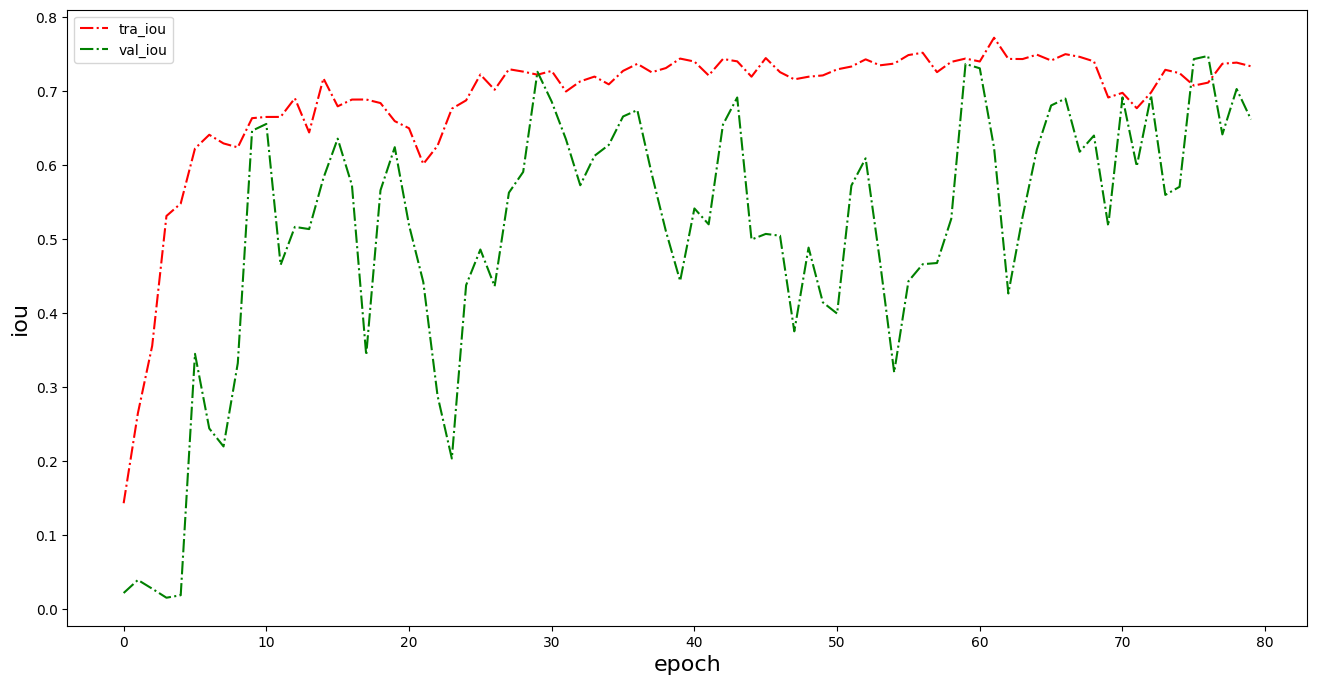

In [ ]:
epoch=[]
for i in range(80):
  epoch.append(i)
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(epoch, tra_iou, c='red', linestyle='-.', label="tra_iou")
plt.plot(epoch, val_iou, c='green', linestyle='-.', label="val_iou")
plt.legend(loc='best')
#plt.yticks(range(0, 1, 0.1))
plt.xlabel("epoch", fontdict={'size': 16})
plt.ylabel("iou", fontdict={'size': 16})
plt.savefig('/content/drive/MyDrive/worm_size/plt_savefig/iou_fig.png')
plt.show()

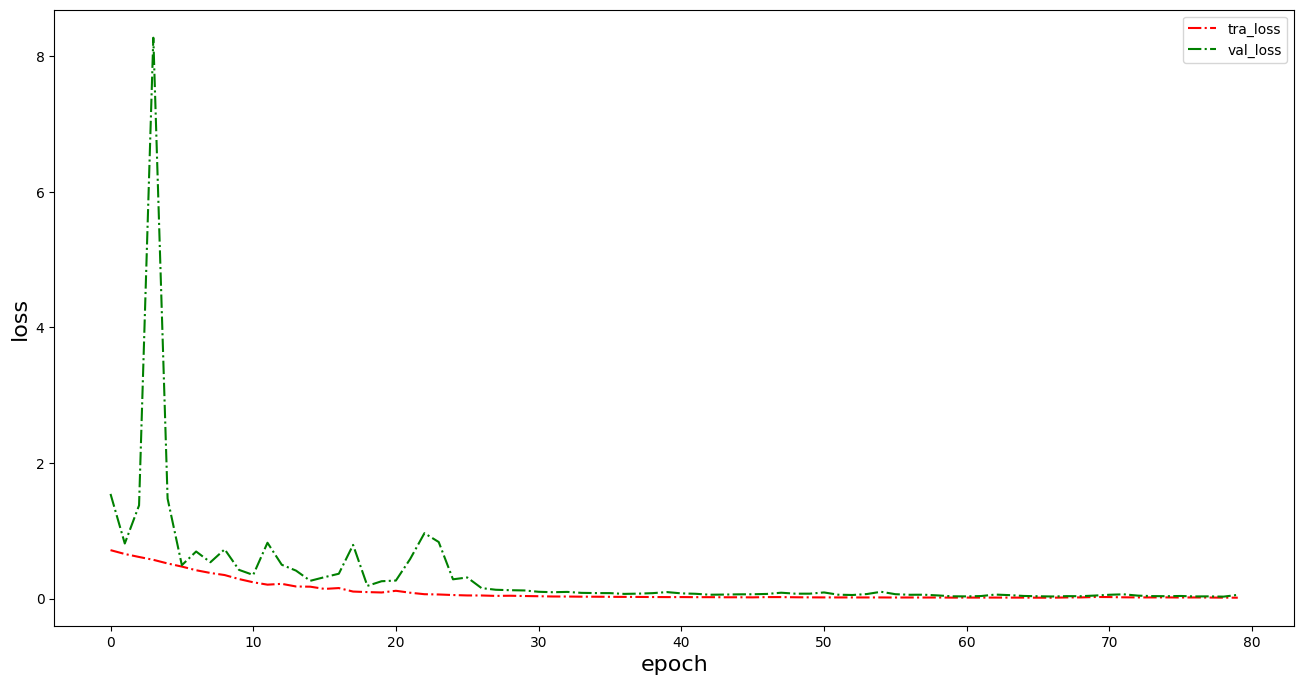

In [ ]:

plt.figure(figsize=(16, 8), dpi=100)
plt.plot(epoch, tra_loss, c='red', linestyle='-.', label="tra_loss")
plt.plot(epoch, val_loss, c='green', linestyle='-.', label="val_loss")
plt.legend(loc='best')
#plt.yticks(range(0, 1, 0.1))
plt.xlabel("epoch", fontdict={'size': 16})
plt.ylabel("loss", fontdict={'size': 16})
plt.savefig('/content/drive/MyDrive/worm_size/plt_savefig/loss_fig.png')
plt.show()